## Modeling
### Experiments with XGBoost for Forecasting Stocks

**Objetivo**: O objetivo deste notebook é fazer experimentos de modelagem com o modelo XGBoost, que será construido de forma iterativa (1 step-ahead forecast)



**Conclusões**:


### 1.0 Imports

In [1]:
%pip install xgboost
%pip install statsmodels
%pip install mlflow
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import logging
from joblib import load, dump
import matplotlib
#from pandas_profiling import ProfileReport

# Time Series Libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  #Autocorrelação (MA), Autocorrelatcao parcial (AR)ve
from pmdarima.arima.utils import ndiffs 

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb
from xgboost import plot_importance

from scipy.stats import shapiro, normaltest, kstest

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow import MlflowClient

In [3]:
import warnings
warnings.filterwarnings('ignore')

### 2.0 Definindo Parâmetros

In [4]:
model_config = {
    "TEST_SIZE": 0.2,
    "TARGET_NAME": "Close",
    "VALIDATION_METRIC": "MAPE",
    "OPTIMIZATION_METRIC": "MSE",
    "FORECAST_HORIZON": 14,
    "REGISTER_MODEL_NAME_VAL": "Stock_Predictor_Validation",
    "REGISTER_MODEL_NAME_INF": "Stock_Predictor_Inference",
    "MODEL_NAME": "xgboost_model",
}

SAMPLE_TICKER_SYMBOL ='VALE3.SA'
stocks_list = ["BOVA11.SA", "BCFF11.SA", "MXRF11.SA", "HGLG11.SA", "XPLG11.SA", "HGRU11.SA", "ITSA4.SA", "TAEE3.SA",
               "FLRY3.SA", "VALE3.SA"]

# paths
ROOT_DATA_PATH = "../data"
RAW_DATA_PATH = os.path.join(ROOT_DATA_PATH, "raw")
PROCESSED_DATA_PATH = os.path.join(ROOT_DATA_PATH, "processed")
OUTPUT_DATA_PATH = os.path.join(ROOT_DATA_PATH, "output")

MODELS_PATH = "../models"


xgboost_model_config = {
    # 'learning_rate': 0.01,
    'max_depth': 11,
    'n_estimators': 40,
    # 'reg_lambda': 10,
    # 'scale_pos_weight': 10,
    # 'seed': 42,
    # 'subsample': 1.0,
    'colsample_bytree': 1.0,
    # 'gamma': 0.01
}

In [5]:
log_format = "[%(name)s][%(levelname)-6s] %(message)s"
logging.basicConfig(format=log_format)
logger = logging.getLogger("Training_XGBoost")
logger.setLevel(logging.INFO)

### 3.0 Criando Funções

In [6]:
def build_features(raw_df: pd.DataFrame, features_list: list, save: bool=True) -> pd.DataFrame:
    """
    This function creates the features for the dataset to be consumed by the
    model
    
    :param raw_df: Raw Pandas DataFrame to create the features of
    :param features_list: The list of features to create

    :return: Pandas DataFrame with the new features
    """

    logger.debug("Building features...")
    final_df_featurized = pd.DataFrame()

    for stock_name in raw_df["Stock"].unique():
        logger.debug("Building features for stock %s..."%stock_name)

        stock_df_featurized = raw_df[raw_df['Stock'] == stock_name].copy()
        
        for feature in features_list:
            
            # create "Time" features
            if feature == "day_of_month":
                stock_df_featurized['day_of_month'] = stock_df_featurized["Date"].apply(lambda x: float(x.day))
            elif feature == "month":
                stock_df_featurized['month'] = stock_df_featurized['Date'].apply(lambda x: float(x.month))
            elif feature == "quarter":
                stock_df_featurized['quarter'] = stock_df_featurized['Date'].apply(lambda x: float(x.quarter))
            elif feature == "week":
                stock_df_featurized['week'] = stock_df_featurized['Date'].apply(lambda x: float(x.week))
            elif feature == "CLOSE_MA_7":
                stock_df_featurized['CLOSE_MA_7'] = stock_df_featurized['Close'].rolling(7).mean()

        # Create "Lag" features
        # The lag 1 feature will become the main regressor, and the regular "Close" will become the target.
        # As we saw that the lag 1 holds the most aucorrelation, it is reasonable to use it as the main regressor.
            elif feature == "Close_lag_1":
                stock_df_featurized['Close_lag_1'] = stock_df_featurized['Close'].shift()

            # Drop nan values because of the shift
            stock_df_featurized = stock_df_featurized.dropna()

        # Concatenate the new features to the final dataframe
        final_df_featurized = pd.concat([final_df_featurized, stock_df_featurized], axis=0)

    try:
        logger.debug("Rounding the features to 2 decimal places...")
        # handle exception when building the future dataset
        final_df_featurized['Close'] = final_df_featurized['Close'].apply(lambda x: round(x, 2))
        final_df_featurized['Close_lag_1'] = final_df_featurized['Close_lag_1'].apply(lambda x: round(x, 2))
        final_df_featurized['CLOSE_MA_7'] = final_df_featurized['CLOSE_MA_7'].apply(lambda x: round(x, 2))
        
    except KeyError as error:
        logger.warning("Key error when rouding numerical features.")
        print(error)
        
    
    if save:
        
        final_df_featurized.to_csv(os.path.join(PROCESSED_DATA_PATH, 'processed_stock_prices.csv'), index=False)

    logger.debug("Features built successfully!")

    return final_df_featurized

In [7]:
def ts_train_test_split(data: pd.DataFrame, target:str, test_size: int):
    """
    Splits the Pandas DataFrame into training and tests sets
    based on a Forecast Horizon value.

    Paramteres:
        data (pandas dataframe): Complete dataframe with full data
        targer (string): the target column name
        test_size (int): the amount of periods to forecast

    Returns:
        X_train, X_test, y_train, y_test dataframes for training and testing
    """

    logger.info("Spliting the dataset...")

    train_df = data.iloc[:-test_size, :]
    test_df = data.iloc[-test_size:, :]
    X_train = train_df.drop(target, axis=1)
    y_train = train_df[target]
    X_test = test_df.drop(target, axis=1)
    y_test = test_df[target]

    return X_train, X_test, y_train, y_test

In [8]:
def visualize_validation_results(pred_df: pd.DataFrame, model_mape: float, model_mae: float, model_wape: float, stock_name: str):
    """
    Creates visualizations of the model validation

    Paramters:
        pred_df: DataFrame with true values, predictions and the date column
        model_mape: The validation MAPE
        model_mae: The validation MAE
        model_wape: The validation WAPE

    Returns:
        None
    """

    logger.info("Vizualizing the results...")

    fig, axs = plt.subplots(figsize=(10, 4))
    # Plot the Actuals
    sns.lineplot(
        data=pred_df,
        x="Date",
        y="Actual",
        label="Testing values",
        ax=axs
    )
    sns.scatterplot(
        data=pred_df,
        x="Date",
        y="Actual",
        ax=axs,
        size="Actual",
        sizes=(80, 80), legend=False
    )

    # Plot the Forecasts
    sns.lineplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        label="Forecast values",
        ax=axs
    )
    sns.scatterplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        ax=axs,
        size="Forecast",
        sizes=(80, 80), legend=False
    )

    axs.set_title(f"Default XGBoost {model_config['FORECAST_HORIZON']} days Forecast for {stock_name}\nMAPE: {round(model_mape*100, 2)}% | MAE: R${model_mae}")
    axs.set_xlabel("Date")
    axs.set_ylabel("R$")
    plt.grid()

    plt.savefig(f"../reports/figures/XGBoost_predictions_{dt.datetime.now().date()}_{stock_name}.png")
    #plt.show()
    return fig


In [9]:
def visualize_forecast(pred_df: pd.DataFrame, historical_df: pd.DataFrame, stock_name: str):
    """
    Creates visualizations of the model forecast

    Paramters:
        pred_df: DataFrame with true values, predictions and the date column
        historical_df: DataFrame with historical values

    Returns:
        None
    """

    logger.info("Vizualizing the results...")

    fig, axs = plt.subplots(figsize=(12, 5), dpi = 2000)
    # Plot the Actuals
    sns.lineplot(
        data=historical_df,
        x="Date",
        y="Close",
        label="Historical values",
        ax=axs
    )
    sns.scatterplot(
        data=historical_df,
        x="Date",
        y="Close",
        ax=axs,
        size="Close",
        sizes=(80, 80),
        legend=False
    )

    # Plot the Forecasts
    sns.lineplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        label="Forecast values",
        ax=axs
    )
    sns.scatterplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        ax=axs,
        size="Forecast",
        sizes=(80, 80),
        legend=False
    )

    axs.set_title(f"Default XGBoost {model_config['FORECAST_HORIZON']-4} days Forecast for {stock_name}")
    axs.set_xlabel("Date")
    axs.set_ylabel("R$")

    #plt.show()
    return fig

In [10]:
def extract_learning_curves(model: xgb.sklearn.XGBRegressor, display: bool=False) -> matplotlib.figure.Figure:
    """
    Extracting the XGBoost Learning Curves.
    Can display the figure or not.

    Args:
        model (xgb.sklearn.XGBRegressor): Fitted XGBoost model
        display (bool, optional): Display the figure. Defaults to False.

    Returns:
        matplotlib.figure.Figure: Learning curves figure
    """

    # extract the learning curves
    learning_results = model.evals_result()

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    plt.suptitle("XGBoost Learning Curves")
    axs[0].plot(learning_results['validation_0']['rmse'], label='Training')
    axs[0].set_title("RMSE Metric")
    axs[0].set_ylabel("RMSE")
    axs[0].set_xlabel("Iterations")
    axs[0].legend()

    axs[1].plot(learning_results['validation_0']['logloss'], label='Training')
    axs[1].set_title("Logloss Metric")
    axs[1].set_ylabel("Logloss")
    axs[1].set_xlabel("Iterations")
    axs[1].legend()

    fig2, axs2 = plt.subplots(figsize=(10, 4))
    plot_importance(model, ax=axs2, importance_type='gain')
    #fig2 = plt.gcf()

    if display:
        plt.show()
    
    return fig, fig2

In [11]:

def train_inference_model(X_train:pd.DataFrame, y_train: pd.Series, stock_name: str) -> xgb.sklearn.XGBRegressor:
    """
    Trains the XGBoost model with the full dataset to perform out-of-sample inference.
    """
    
    # use existing params
    xgboost_model = xgb.XGBRegressor(
        eval_metric=["rmse", "logloss"],
    )

    # train the model
    xgboost_model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train)],
        verbose=0
    )

    return xgboost_model

In [12]:
def test_model_one_shot(X: pd.DataFrame, y: pd.Series, forecast_horizon: int, stock_name: str) -> pd.DataFrame:
    """
    Make predictions for the past `forecast_horizon` days using a XGBoost model.
    This model is validated using One Shot Training, it means that we train the model
    once, and them perform the `forecast_horizon` predictions only loading the mdoel.
    
    Parameters:
        X (pandas dataframe): The input data
        y (pandas Series): The target data
        forecast_horizon (int): Number of days to forecast
        
    Returns:
        pred_df: Pandas DataFrame with the forecasted values
    """

    # Create empty list for storing each prediction
    predictions = []
    actuals = []
    dates = []
    X_testing_df = pd.DataFrame()
    
    # get the one-shot training set
    X_train = X.iloc[:-forecast_horizon+4, :]
    y_train = y.iloc[:-forecast_horizon+4]

    final_y = y_train.copy()
    # # start the mlflow tracking
    mlflow.set_experiment(experiment_name="model-testing")
    with mlflow.start_run(run_name=f"xgboost_{stock_name}") as run:

        # fit the model again with the best parameters
        xgboost_model = xgb.XGBRegressor(
            eval_metric=["rmse", "logloss"],
            **xgboost_model_config
        )

        logger.debug("Fitting the model...")
        xgboost_model.fit(
            X_train.drop("Date", axis=1),
            y_train,
            eval_set=[(X_train.drop("Date", axis=1), y_train)],
            verbose=0
        )

        # Iterate over the dataset to perform predictions over the forecast horizon, one by one.
        # After forecasting the next step, we need to update the "lag" features with the last forecasted
        # value
        for day in range(forecast_horizon-4, 0, -1):
            
            if day != 1:
                # the testing set will be the next day after the training and we use the complete dataset
                X_test = X.iloc[-day:-day+1,:]
                y_test = y.iloc[-day:-day+1]

            else:
                # need to change the syntax for the last day (for -1:-2 will not work)
                X_test = X.iloc[-day:,:]
                y_test = y.iloc[-day:]

            # only the first iteration will use the true value of Close_lag_1
            # because the following ones will use the last predicted value
            # so we simulate the process of predicting out-of-sample
            if len(predictions) != 0:
                
                # ------------ UPDATE THE "LAG_1" FEATURE USING THE LAST PREDICTED VALUE ------------
                # we need to update the X_test["Close_lag_1"] value, because
                # it should be equal to the last prediction (the "yesterday" value)
                X_test.iat[0, -1] = predictions[-1]

                # ------------ UPDATE THE "MA_7" FEATURE, USING THE LAST 7 "Target" VALUES ------------
                # re-calculating the Moving Average.
                # we need to extract he last closing prices before today
                # last_closing_princes = final_y.iloc[:-day] # thats -11
                last_closing_princes_ma = final_y.rolling(7).mean()
                last_ma = last_closing_princes_ma.values[-1]
                X_test.iat[0, -2] = last_ma

                X_testing_df = pd.concat([X_testing_df, X_test], axis=0)

            else:
                # we jump the first iteration because we do not need to update anything.
                X_testing_df = pd.concat([X_testing_df, X_test], axis=0)

                pass

            # make prediction
            prediction = xgboost_model.predict(X_test.drop("Date", axis=1))
            final_y = pd.concat([final_y, pd.Series(prediction[0])], axis=0)
            final_y = final_y.reset_index(drop=True)

            # store the results
            predictions.append(prediction[0])
            actuals.append(y_test.values[0])
            dates.append(X_test["Date"].max())

        pred_df = pd.DataFrame(list(zip(dates, actuals, predictions)), columns=["Date", 'Actual', 'Forecast'])
        pred_df["Forecast"] = pred_df["Forecast"].astype("float64")

        logger.debug("Calculating the evaluation metrics...")
        model_mape = round(mean_absolute_percentage_error(actuals, predictions), 4)
        model_rmse = round(np.sqrt(mean_squared_error(actuals, predictions)), 2)
        model_mae = round(mean_absolute_error(actuals, predictions), 2)
        model_wape = round((pred_df.Actual - pred_df.Forecast).abs().sum() / pred_df.Actual.sum(), 2)

        pred_df["MAPE"] = model_mape
        pred_df["MAE"] = model_mae
        pred_df["WAPE"] = model_wape
        pred_df["RMSE"] = model_rmse
        pred_df["Model"] = str(type(xgboost_model)).split('.')[-1][:-2]

        # Plotting the Validation Results
        validation_metrics_fig = visualize_validation_results(pred_df, model_mape, model_mae, model_wape, stock_name)

        # Plotting the Learning Results
        learning_curves_fig, feat_imp = extract_learning_curves(xgboost_model)

        # ---- logging ----
        logger.debug("Logging the results to MLFlow")
        parameters = xgboost_model.get_xgb_params()
        #parameters = xgboost_model_config
        mlflow.log_params(parameters)
        mlflow.log_param("features", list(X_test.columns))

        # log the metrics
        mlflow.log_metric("MAPE", model_mape)
        mlflow.log_metric("RMSE", model_rmse)
        mlflow.log_metric("MAE", model_mae)
        mlflow.log_metric("WAPE", model_wape)

        # log the figure
        mlflow.log_figure(validation_metrics_fig, "validation_results.png")
        mlflow.log_figure(learning_curves_fig, "learning_curves.png")
        mlflow.log_figure(feat_imp, "feature_importance.png")

        # get model signature
        model_signature = infer_signature(X_train, pd.DataFrame(y_train))

        # log the model to mlflow
        mlflow.xgboost.log_model(
            xgb_model=xgboost_model,
            artifact_path=f"xgboost_model_{stock_name}",
            input_example=X_train.head(),
            signature=model_signature
        )

        # execute the CD pipeline
        #cd_pipeline(run.info, y_train, pred_df, model_mape, stock_name)

    
    return pred_df, X_testing_df

## 4.0 Executando

### 4.1 One Shot training and prediction

In [13]:
logger.debug("Loading the featurized dataset..")
features_list = ["day_of_month", "month", "quarter", "week", "Close_lag_1"]
stock_df_feat_all = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'processed_stock_prices.csv'), parse_dates=["Date"])
stock_df_feat=stock_df_feat_all[stock_df_feat_all["Stock"] == SAMPLE_TICKER_SYMBOL].copy().drop("Stock", axis=1)
stock_df_feat.tail()

,Date,Close,day_of_month,month,quarter,week,CLOSE_MA_7,Close_lag_1
28019,2023-12-11,72.86,11.0,12.0,4.0,50.0,73.32,72.80
28020,2023-12-12,72.99,12.0,12.0,4.0,50.0,73.18,72.86
28021,2023-12-13,73.00,13.0,12.0,4.0,50.0,72.86,72.99
28022,2023-12-14,73.40,14.0,12.0,4.0,50.0,72.78,73.00
28023,2023-12-15,73.86,15.0,12.0,4.0,50.0,72.86,73.40


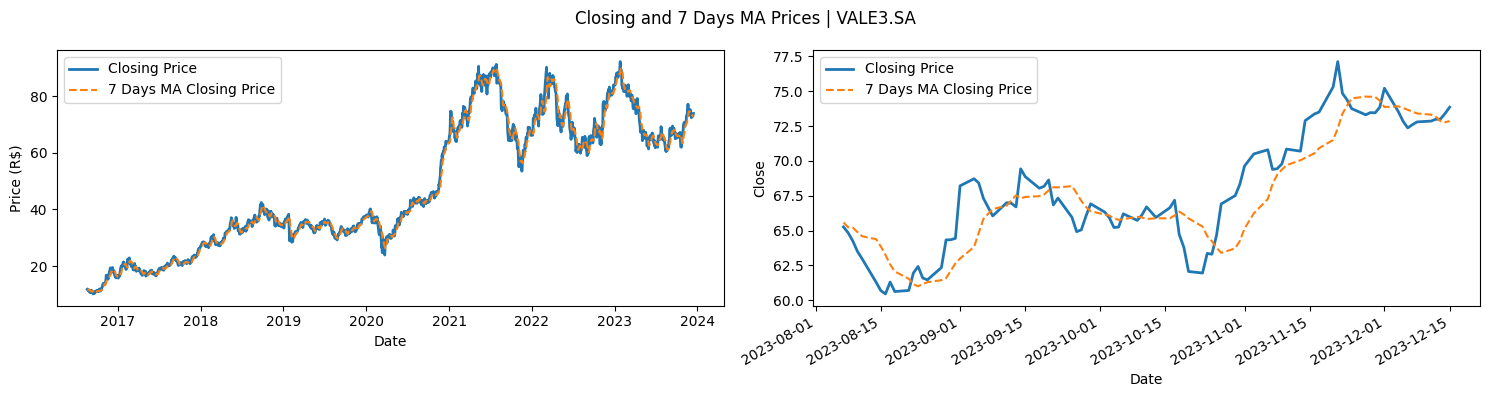

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

sns.lineplot(    data=stock_df_feat.tail(365*5),    x='Date',    y='Close',    label='Closing Price',    ax=axs[0],    lw=2)
sns.lineplot(    data=stock_df_feat.tail(365*5),    x='Date',    y='CLOSE_MA_7',    label='7 Days MA Closing Price',    ax=axs[0],    ls='--')
sns.lineplot(    data=stock_df_feat.tail((365 * 3) // 12),    x='Date',    y='Close',    label='Closing Price',    ax=axs[1],    lw=2)
sns.lineplot(    data=stock_df_feat.tail((365 * 3) // 12),    x='Date',    y='CLOSE_MA_7',    label='7 Days MA Closing Price',    ax=axs[1],    ls='--')

plt.suptitle(f"Closing and 7 Days MA Prices | {SAMPLE_TICKER_SYMBOL}")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Price (R$)")
axs[1].set_xticks(axs[1].get_xticks())
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30, ha='right')
plt.tight_layout()
plt.show()

[Training_XGBoost][INFO  ] Testing the model for the stock: BOVA11.SA...
[Training_XGBoost][INFO  ] Vizualizing the results...
[Training_XGBoost][INFO  ] Testing the model for the stock: BCFF11.SA...
[Training_XGBoost][INFO  ] Vizualizing the results...
[Training_XGBoost][INFO  ] Testing the model for the stock: MXRF11.SA...
[Training_XGBoost][INFO  ] Vizualizing the results...
[Training_XGBoost][INFO  ] Testing the model for the stock: HGLG11.SA...
[Training_XGBoost][INFO  ] Vizualizing the results...
[Training_XGBoost][INFO  ] Testing the model for the stock: XPLG11.SA...
[Training_XGBoost][INFO  ] Vizualizing the results...
[Training_XGBoost][INFO  ] Testing the model for the stock: HGRU11.SA...
[Training_XGBoost][INFO  ] Vizualizing the results...
[Training_XGBoost][INFO  ] Testing the model for the stock: ITSA4.SA...
[Training_XGBoost][INFO  ] Vizualizing the results...
[Training_XGBoost][INFO  ] Testing the model for the stock: TAEE3.SA...
[Training_XGBoost][INFO  ] Vizualizing t

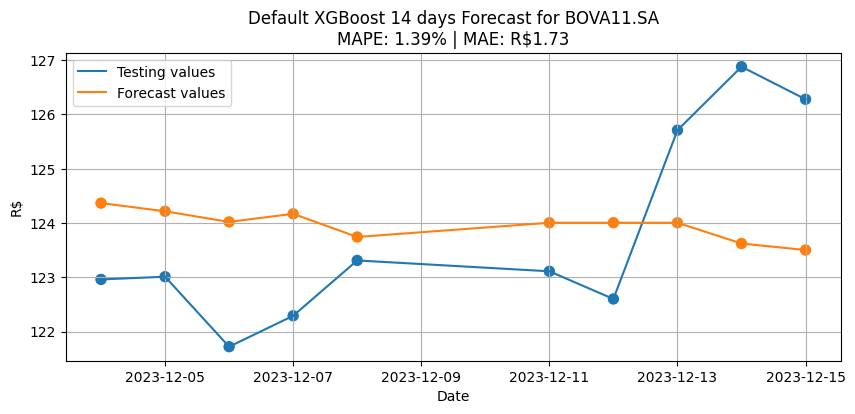

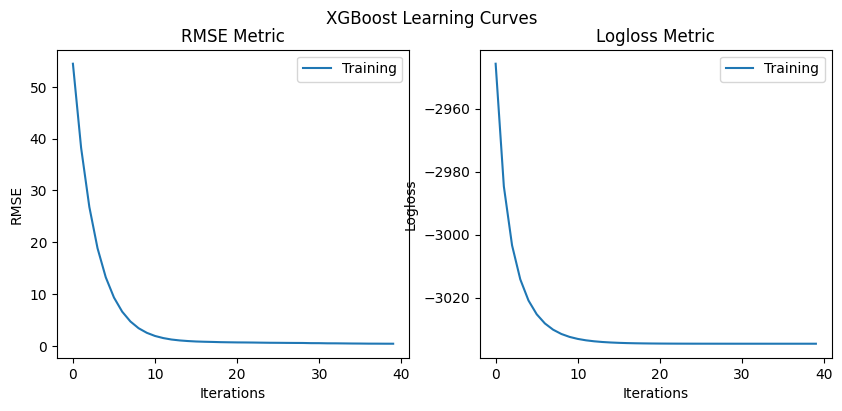

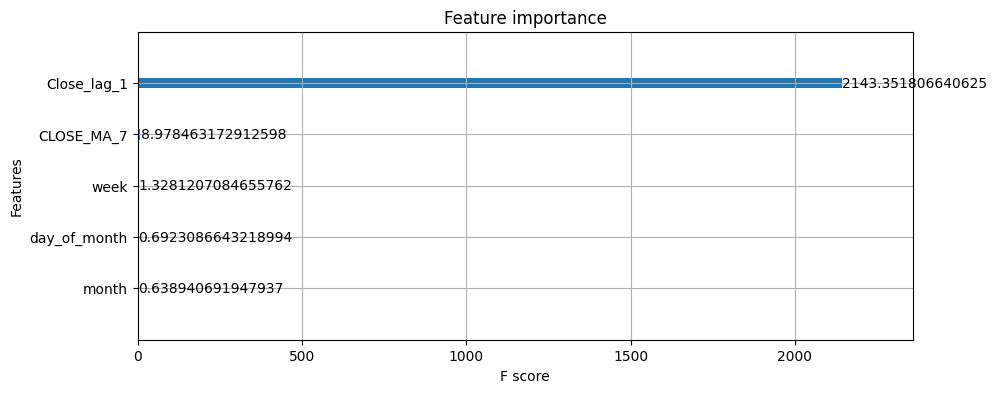

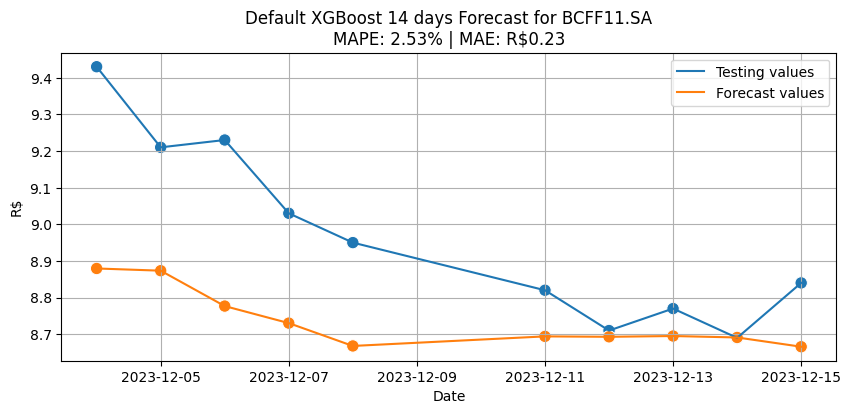

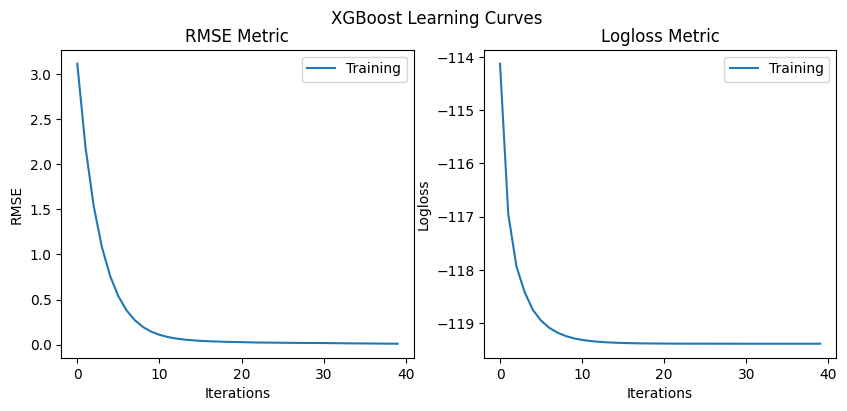

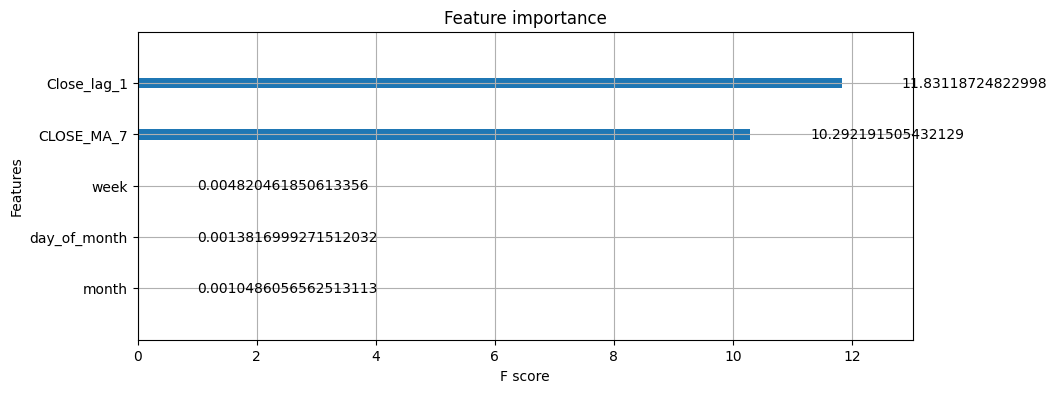

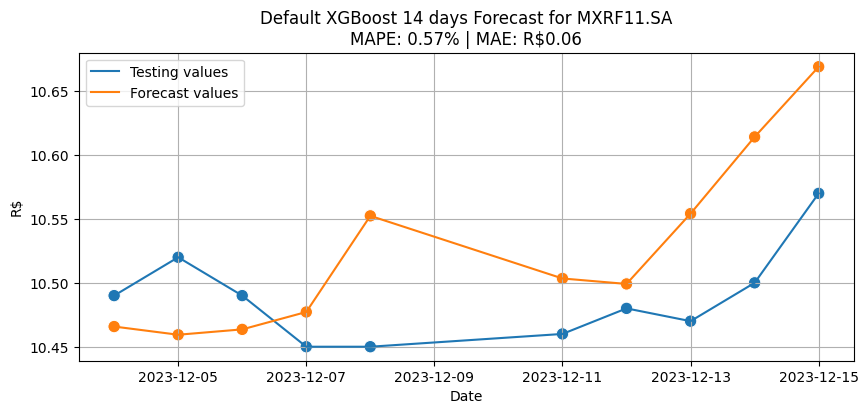

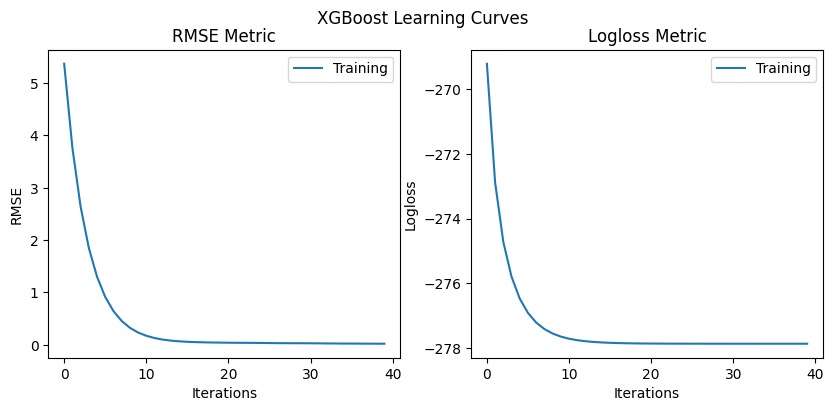

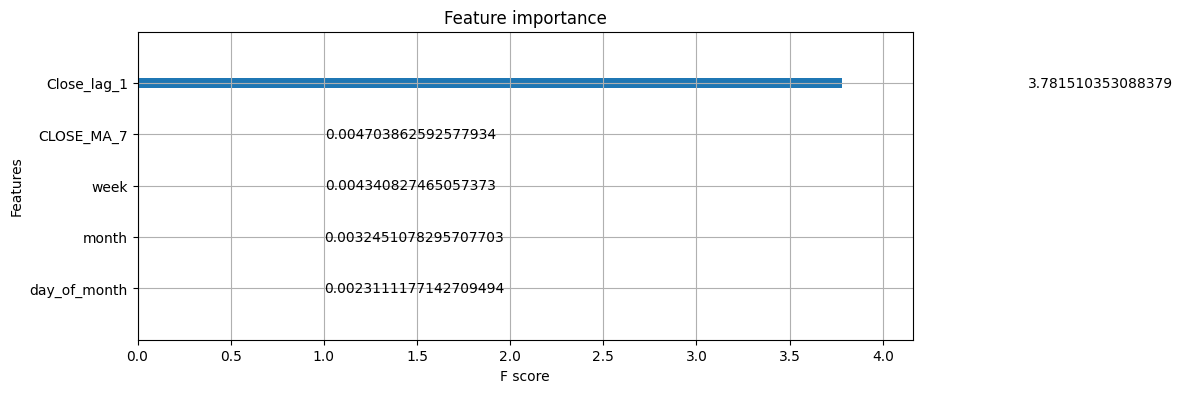

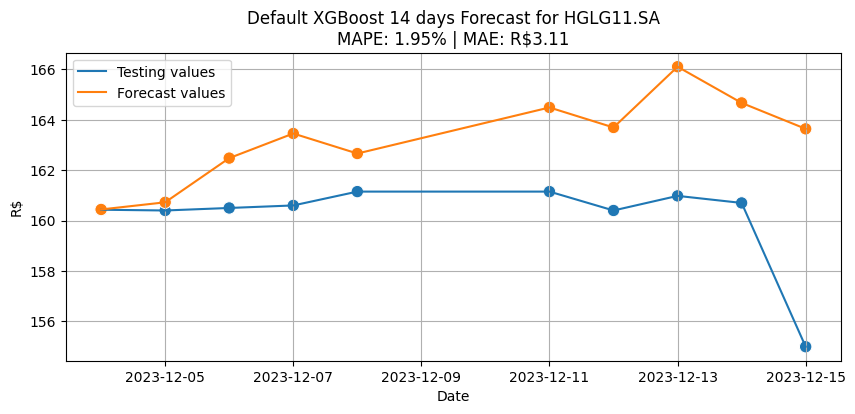

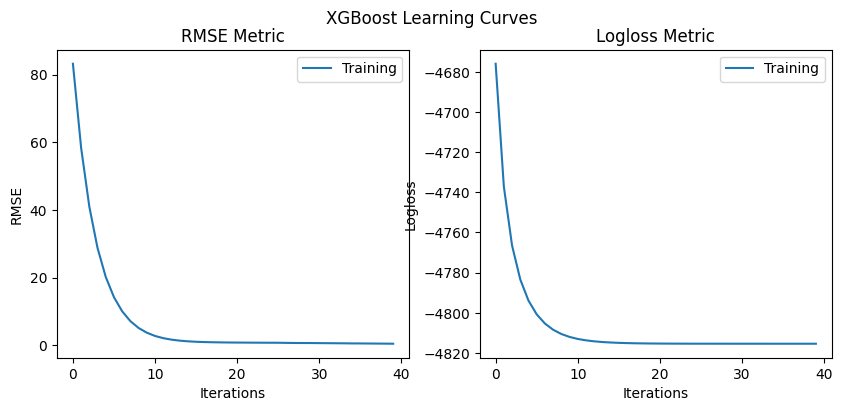

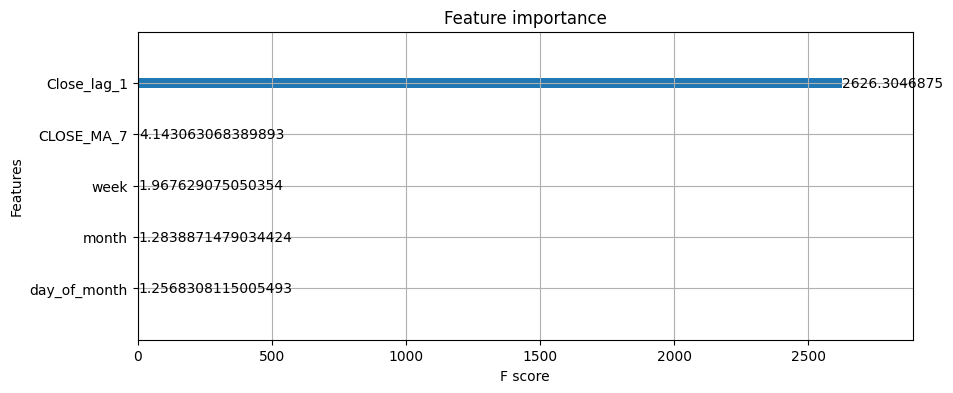

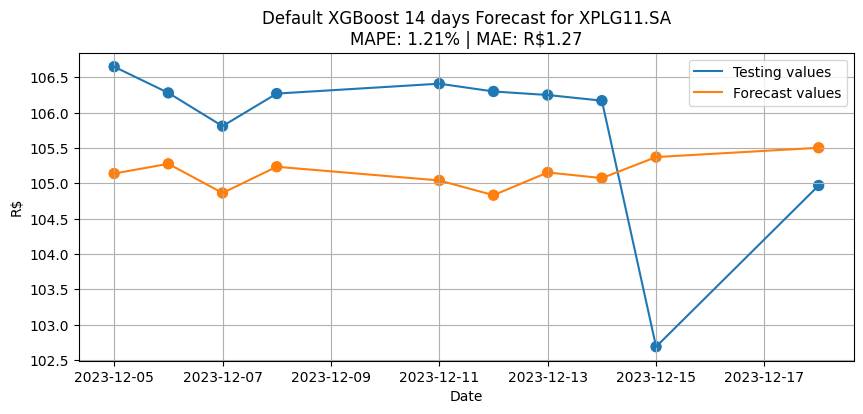

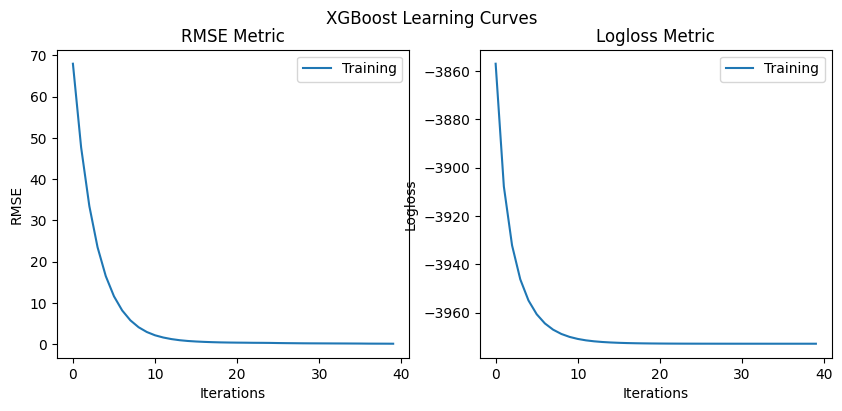

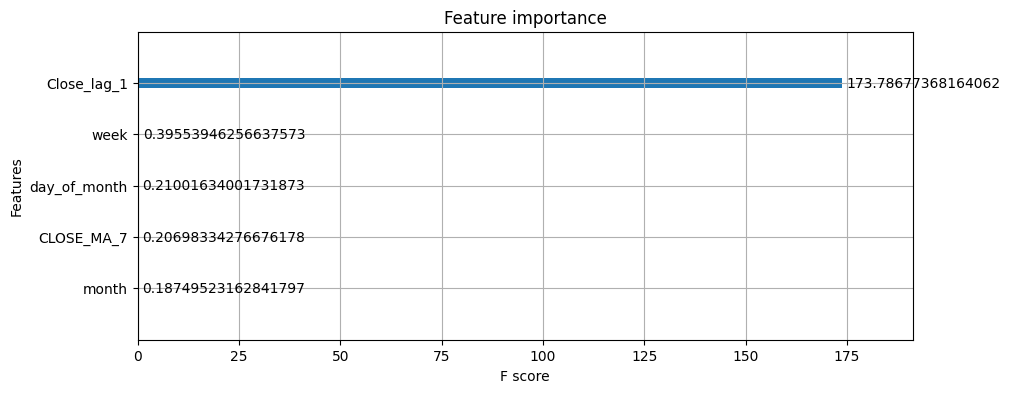

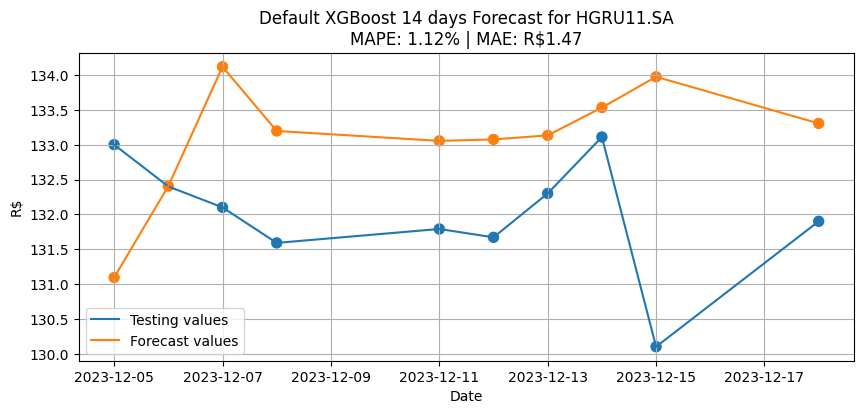

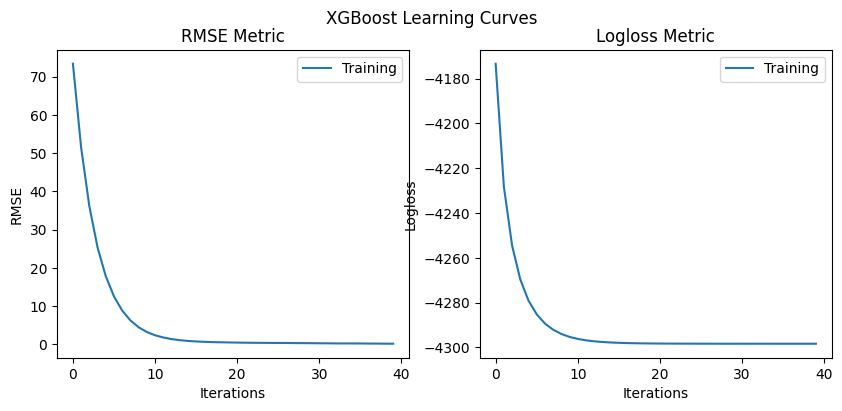

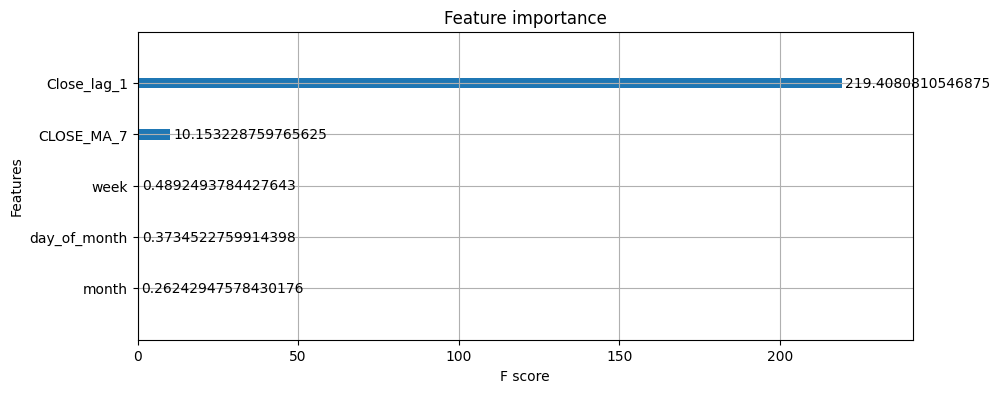

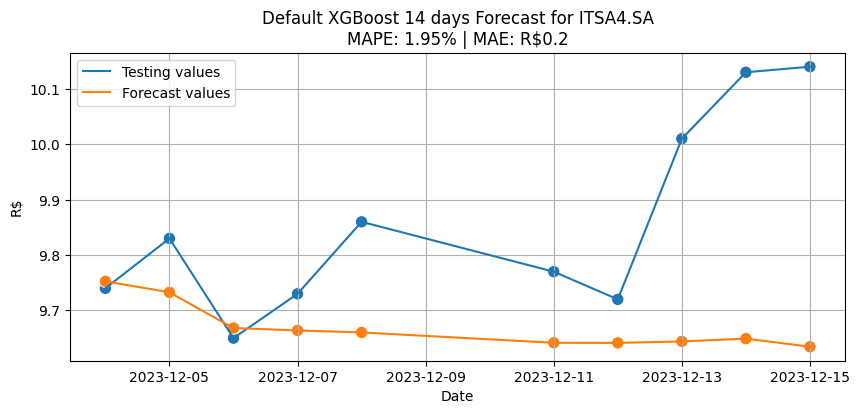

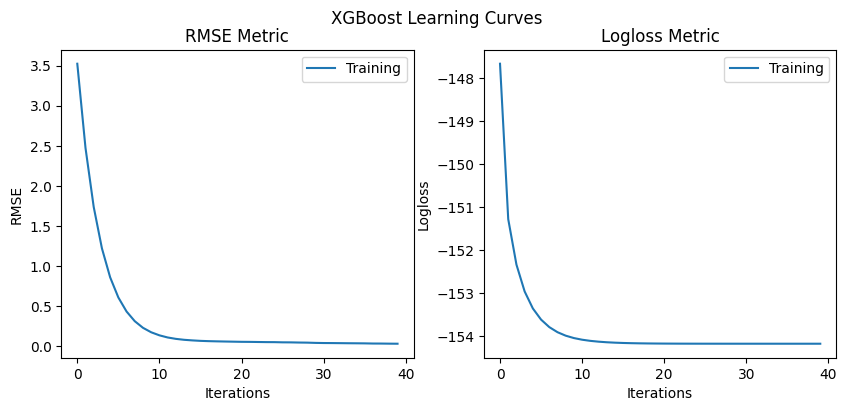

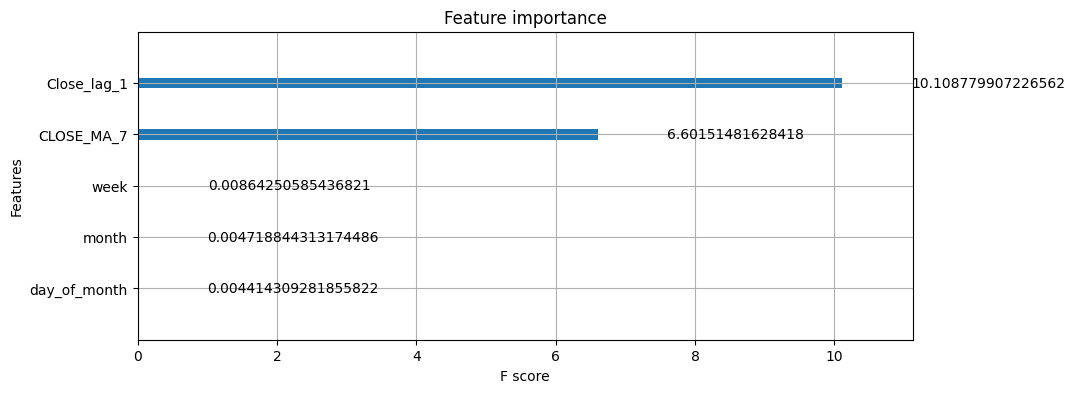

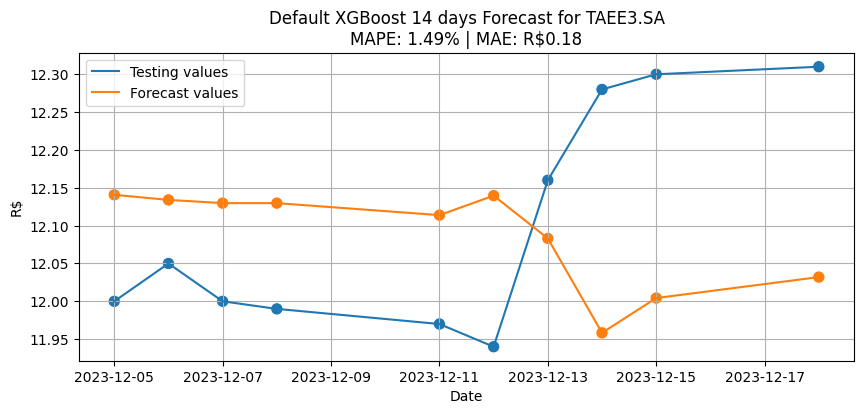

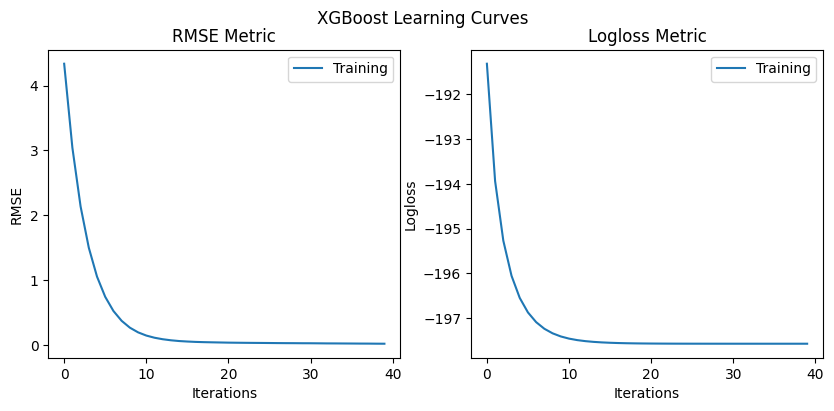

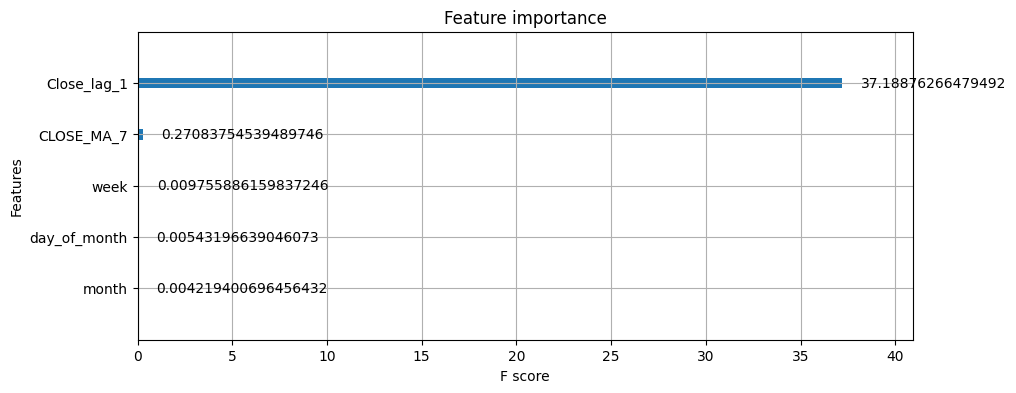

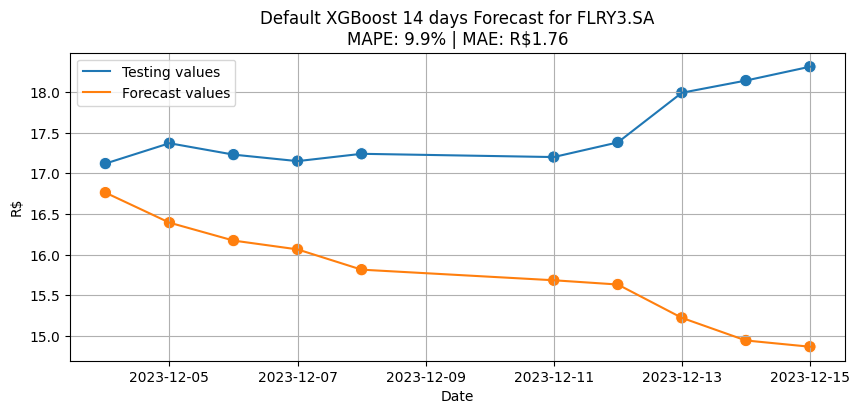

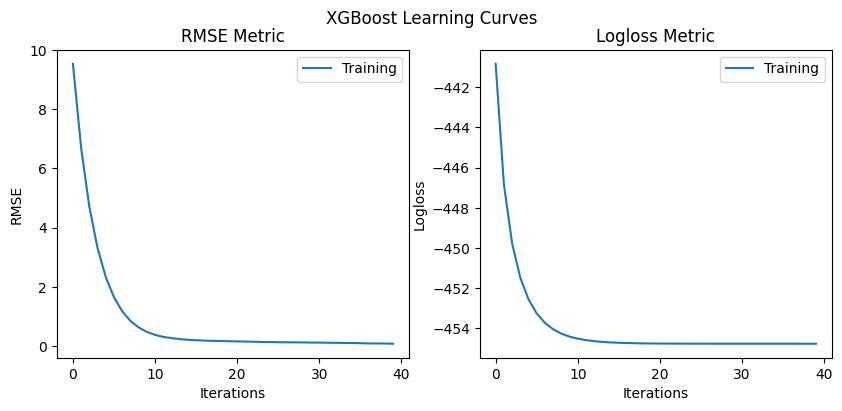

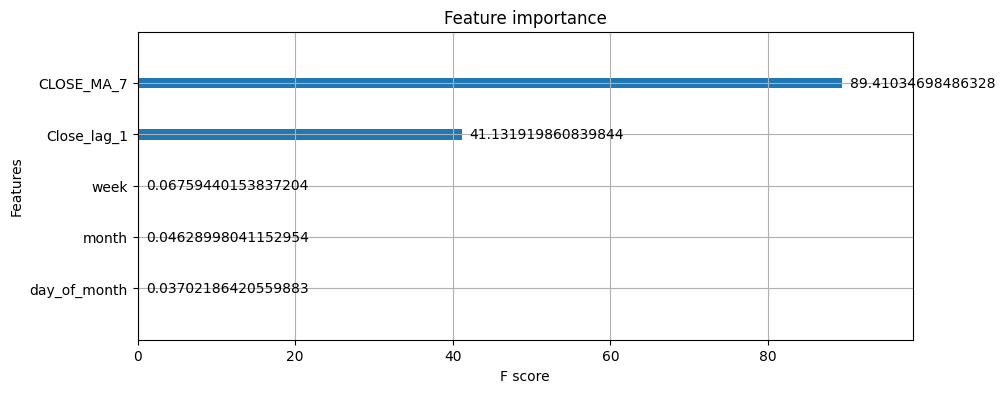

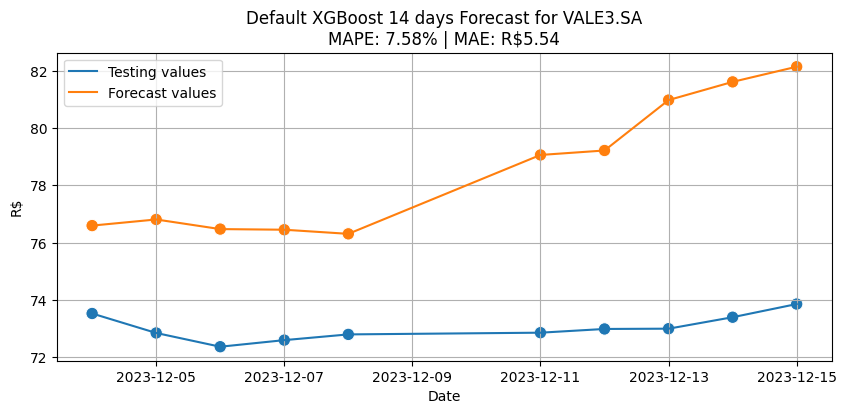

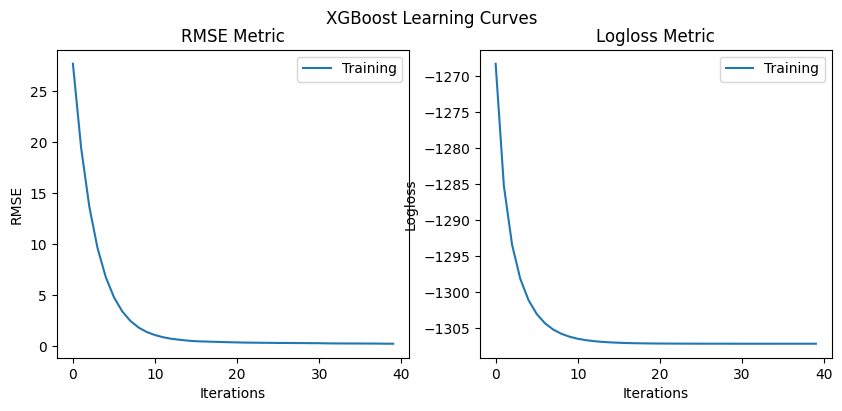

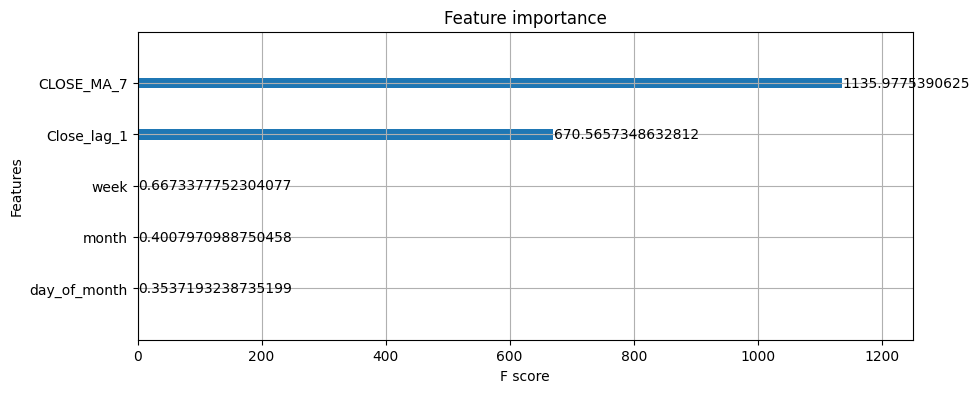

In [15]:

# iterate over the stocks
validation_report_df = pd.DataFrame()

for stock_name in stock_df_feat_all["Stock"].unique():

    logger.info("Testing the model for the stock: %s..."%stock_name)
    stock_df_feat = stock_df_feat_all[stock_df_feat_all["Stock"] == stock_name].copy().drop("Stock", axis=1)
    
    predictions_df, X_testing_df = test_model_one_shot(
        X=stock_df_feat.drop([model_config["TARGET_NAME"]], axis=1),
        y=stock_df_feat[model_config["TARGET_NAME"]],
        forecast_horizon=model_config['FORECAST_HORIZON'],
        stock_name=stock_name
    )

    predictions_df["Stock"] = stock_name
    predictions_df["Training_Date"] = dt.datetime.today().date()

    validation_report_df = pd.concat([validation_report_df, predictions_df], axis=0)

logger.debug("Writing the testing results dataframe...")
validation_report_df = validation_report_df.rename(columns={"Forecast": "Price"})
validation_report_df["Class"] = "Testing"

validation_report_df.to_csv(os.path.join(OUTPUT_DATA_PATH, 'validation_stock_prices.csv'), index=False)

In [16]:
avg_scores_df = validation_report_df.groupby("Stock", as_index=False).mean()[['Stock', 'MAPE', 'MAE']]
print(avg_scores_df[['MAPE', 'MAE']].mean())
# With Wrong MA_7
# MAPE    0.03485
# MAE     1.38500
# Without MA_7
# MAPE    0.03695
# MAE     1.75500
# Corrected MA_7
# MAPE    0.02845
# MAE     1.07600
# Corrected MA_30
# MAPE    0.02845
# MAE     1.07600

MAPE    0.02969
MAE     1.55500
dtype: float64


In [17]:
avg_scores_df.sort_values("MAPE")

,Stock,MAPE,MAE
6,MXRF11.SA,0.0057,0.06
4,HGRU11.SA,0.0112,1.47
9,XPLG11.SA,0.0121,1.27
1,BOVA11.SA,0.0139,1.73
7,TAEE3.SA,0.0149,0.18
3,HGLG11.SA,0.0195,3.11
5,ITSA4.SA,0.0195,0.20
0,BCFF11.SA,0.0253,0.23
8,VALE3.SA,0.0758,5.54
2,FLRY3.SA,0.0990,1.76


In [18]:
avg_scores_df.sort_values("MAPE")

,Stock,MAPE,MAE
6,MXRF11.SA,0.0057,0.06
4,HGRU11.SA,0.0112,1.47
9,XPLG11.SA,0.0121,1.27
1,BOVA11.SA,0.0139,1.73
7,TAEE3.SA,0.0149,0.18
3,HGLG11.SA,0.0195,3.11
5,ITSA4.SA,0.0195,0.20
0,BCFF11.SA,0.0253,0.23
8,VALE3.SA,0.0758,5.54
2,FLRY3.SA,0.0990,1.76


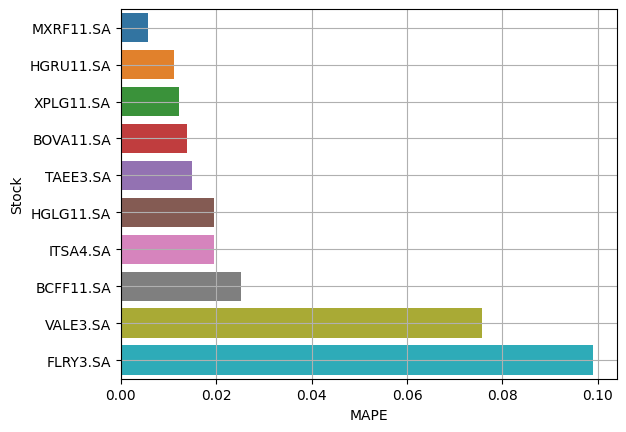

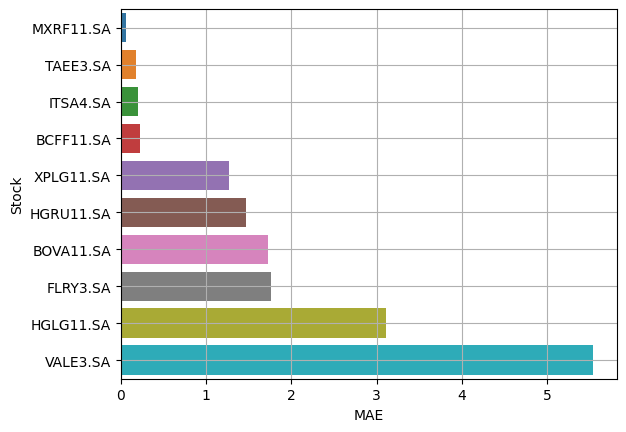

In [19]:
avg_scores_df = avg_scores_df.sort_values("MAPE")
sns.barplot(data=avg_scores_df, y='Stock', x='MAPE')
plt.grid()
plt.show()
avg_scores_df = avg_scores_df.sort_values("MAE")
sns.barplot(data=avg_scores_df, y='Stock', x='MAE')
plt.grid()
plt.show()